Dashboard building with temperature and abudannce of specific pollinators

import the necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

Import Data

In [2]:
df = pd.read_csv("pollinator_count_data-final.csv", sep = ',')
y = pd.read_csv("plant_on_campus_frequency.csv", sep = ',')

Clean up the imported data

In [3]:
#want to convert acronyms to full names 
#(hoverfly, honeybee, bumblebee, sweatbee, wasp, leafcutter, fly, beatle, butterfly)

def clean_data(df):

    #setting to print all the rows 
    pd.set_option('display.max_rows', None)

    #plants on campus data 
    df_frequency = pd.read_csv("plant_on_campus_frequency.csv",sep = ',')

    #convert european carder bee ( ECB), mason bee and carpenter bee to the leafcutter bee group (LF)
    df['pollinator'] = df['pollinator'].replace(['ECB','MB','CB'],'LB')
    #convert No information (NI) and unidentified bee (UB) to the Other pollinator group (OP)
    df['pollinator'] = df['pollinator'].replace(['NI','UB'],'OP')

    #replacing values within dataframe to favored/changed names exp. Bumble
    df['pollinator'] = df['pollinator'].replace(['BUT'],'Butterfly')
    df['pollinator'] = df['pollinator'].replace(['W'],'Wasp')
    df['pollinator'] = df['pollinator'].replace(['HF'],'Hover Fly')
    df['pollinator'] = df['pollinator'].replace(['BVO','BS','BMI','BME','BU','BI','BFL','BF','BB'],'Bumble')
    df['pollinator'] = df['pollinator'].replace(['SB'],'Sweat')
    df['pollinator'] = df['pollinator'].replace(['HB'],'Honey')
    df['pollinator'] = df['pollinator'].replace(['LB'],'Leaf Cutter')



    #using where statement to seperate OP to beetles and flies 

    # beetle 
    df['pollinator'] = np.where((df['pollinator'] == 'OP') & (df['insect_order'] == 'coleoptera'), 'Beetle', df['pollinator'])
    #print(df['pollinator'])

    # flies 
    df['pollinator'] =  np.where((df['pollinator'] == 'OP') & (df['insect_order'] == 'diptera'),'Fly',df['pollinator'] )
    #print(df[['pollinator','insect_order']])

    #droping all other pollinator from the data because not interested in other pollinators in data analysis
    df = df.drop(df[df['pollinator'] == 'OP'].index)
    #print(df[['pollinator','insect_order']])

    return df

In [4]:

#find the count of pollinator groups in the csv and return a percentage
pol_count = df.groupby(['pollinator'])['pollinator'].count()
print('The individual pollinator count: \n', pol_count)
print('The # of total pollinators: \n', len(df))
print('Percentage of pollinator distribution count: \n',(pol_count/len(df))*100)

The individual pollinator count: 
 pollinator
BB      13
BF       5
BFL     82
BI      32
BME     33
BMI     41
BS      12
BU       9
BUT     17
BVO    375
HB     581
HF     304
LB      20
MB       9
NI      24
OP      60
SB     267
UB       2
W       48
Name: pollinator, dtype: int64
The # of total pollinators: 
 1934
Percentage of pollinator distribution count: 
 pollinator
BB      0.672182
BF      0.258532
BFL     4.239917
BI      1.654602
BME     1.706308
BMI     2.119959
BS      0.620476
BU      0.465357
BUT     0.879007
BVO    19.389866
HB     30.041365
HF     15.718718
LB      1.034126
MB      0.465357
NI      1.240951
OP      3.102378
SB     13.805584
UB      0.103413
W       2.481903
Name: pollinator, dtype: float64


Adding in data regarding the date into seperate columns

In [5]:
def give_time(df):

    df['sample_date'] = pd.to_datetime(df['sample_date'])
    df['month'] = df['sample_date'].dt.month
    df['Week'] = df['sample_date'].dt.week -20
    df['day_of_year'] = df['sample_date'].dt.dayofweek
    
   

    #Get a column of the start of the week of all datetime objects
    df['datetime_monday_week'] = df['sample_date'].dt.to_period('W').dt.start_time
    df['dates'] = df['sample_date'].dt.strftime("%b %d, %Y")
    
    return df
	


Putting in temperature percentages

In [6]:
# A function that intakes a df column and returns a list of the percent differences with the first value being 
#the baseline percentage of 100.

def turn_into_percent_difference(old_series):
    initial_value = old_series[0]
    new_list = []
    for index in old_series:
        new_list.append((index/ initial_value)*100)
    return new_list

Define a function which would give the average temperature 

In [7]:
def line_temp_plot(data_set):
	
	#TEST to find missing temperatures in data 
	#Result : found missing time data for C0: E and C10: A --> both have no data for count in pollinator
	#must hardcode into data as no pollinator 
	count_test = data_set.groupby(['location_number','time_code'])['location_number'].count()
	count_test = count_test.reset_index(name='counts')
	#print(count_test)

	#results 
	# week = 20 , air_temp = 15, time_code = 'E', location_number = 'CO', counts = 0
	# week = 35 , air_temp = 23, time_code = 'A', location_number = 'C10', counts = 0
	#print(data_set.columns)
	num_plot_week = data_set.groupby(['Week','air_temp','time_code','location_number'])['air_temp'].count()
	num_plot_week = num_plot_week.reset_index(name = 'counts')
	pd.set_option('display.max_rows', None)
	
	num_plot_week.loc[len(num_plot_week)] = [20,15,'E','C0',0]
	num_plot_week.loc[len(num_plot_week)] = [35,23,'A','C10',0]
	#print('test_run','\n',num_plot_week)


	num_plot_week = num_plot_week.groupby(['Week'])['air_temp'].mean()
	num_plot_week = num_plot_week.reset_index(name = 'avg_air_temp')
	data_set = pd.merge(data_set, num_plot_week)
	
	#print(data_set)
	return data_set

In [256]:
def average_per_week(pollinator,dates):
	print(dates[0],dates[1])

	#observation data for pollinators
	data_set = df
	data_set = clean_data(data_set)
	data_set = give_time(data_set)
	#Test Case :1
	# #print("Test Case : 
	#1", "\n",data_set['datetime_monday_week'])
	# 
	# #find the total number of pollinators according to location number and time code
	if(pollinator == 'average'):
		data_set['total_counts'] = data_set.groupby(['location_number','time_code'])['location_number'].transform('count')
	else:
		#print(data_set['pollinator'].unique())
		data_set = data_set[(data_set['pollinator'] == pollinator)]
		#print(data_set)
		data_set['total_counts'] = data_set.groupby(['location_number','time_code'])['location_number'].transform('count')
	
	#Test Case :2
	#print("Test Case : 2", "\n",data_set)

	#creating average temerapture for all plots 
	data_set = line_temp_plot(data_set)


	#getting the average pollinator mean 
	data_set['pol_mean'] = data_set.groupby(['datetime_monday_week'])['total_counts'].transform('mean')

	#finding the unique average air temperature by using .last()
	data_set = data_set.groupby(['datetime_monday_week','pol_mean'])['avg_air_temp'].last()
	data_set = data_set.reset_index(name = 'avg_temp')
	#print(data_set)

	#print(data_set['dates'])
	#print(pd.to_datetime(df['dates']))
	#data_set['dates'] = pd.to_datetime(df['dates'])
	data_set = data_set.sort_values(by = 'datetime_monday_week')
	data_set['dates'] =data_set['datetime_monday_week'].dt.strftime("%b %d")
	data_set['dates'] = data_set['dates'].astype('str')
	print(data_set['dates'])
	#print(data_set.dtypes)

	data_set['Abundance_percentage'] = turn_into_percent_difference(data_set['pol_mean'])
	data_set['Temp_percentage'] = turn_into_percent_difference(data_set['avg_temp'])

	min = dates[0]
	#print(min,type(min), data_set['dates'][0],type(data_set['dates'][0]))
	#print(min == data_set['dates'][0])
	#print(data_set['dates'] == min )
	indices_1 = data_set.index[data_set['dates'] == min].tolist()
	print(indices_1)
	
	max = dates[1]
	#print(max,type(max))
	indices_2 = data_set.index[data_set['dates'] == max].tolist()
	print(indices_2)
	#max_index = data_set[data_set['dates'] == max].index[0]
	#print(max_index)
	print(indices_1[0],indices_2[0])
	data_set = data_set.iloc[int(indices_1[0]):int(indices_2[0])]
	#data_set = data_set.to_frame()
	#print(df2)
	
	#print(df2,'spagetti')
	#plotting the graph

	fig, ax = plt.subplots()
	ax.plot(data_set['dates'], data_set['Abundance_percentage'], linewidth=3, color='#63B7B7')
	ax.plot(data_set['dates'], data_set['Temp_percentage'], linewidth=3, color='#FF6961')
	plt.xticks(rotation = 60, horizontalalignment='right')
	ax.legend(['Visitations', 'Temperature'])
	ax.set_ylabel('Percent Difference (%)')
	ax.set_xlabel('Week')
	ax.set_title('Percent Difference of Average Visition Number and \n Temperature For Each Week Between June 12 and September 11th.',
             fontname = 'Georgia', 
             fontsize= 16, 
             pad=30)
	ax.grid()

	plt.show()

	

May 23 Aug 22
0     May 23
1     May 30
2     Jun 06
3     Jun 13
4     Jun 20
5     Jun 27
6     Jul 04
7     Jul 11
8     Jul 18
9     Jul 25
10    Aug 01
11    Aug 08
12    Aug 15
13    Aug 22
14    Aug 29
15    Sep 05
16    Sep 12
Name: dates, dtype: object
[0]
[13]
0 13


C:\Users\lizzy\AppData\Local\Temp/ipykernel_4776/2508569428.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['sample_date'].dt.week -20


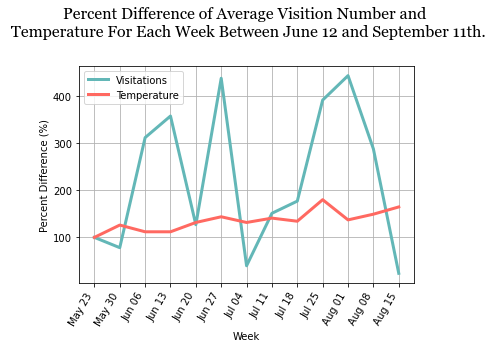

In [257]:
#print(df)
average_per_week('Bumble',['May 23','Aug 22'])

Starting the building of a dashboard
import the necessary libraries

In [258]:

import plotly.express as px

import ipywidgets as widgets

import calendar

#from ipywidgets import interact
#%matplotlib widget
import seaborn as sb

Create the dashboard data filter parameters

In [220]:
#using ipywidgets
#data_set, request
df = clean_data(df)
df = give_time(df)


#create information for slider
#adding widget for sliding months to get specific range of month
df = df.sort_values(by = 'datetime_monday_week')
df['dates'] =df['sample_date'].dt.strftime("%b %d")
months = df['dates'].unique()

requests = df['pollinator'].unique()
requests = np.append('average',requests)
print(requests)

#dropdown 1
dd1 = widgets.Dropdown(options = requests,description = 'type of pollinator')

#adding sliding tool
#create slider for the informtion 
slider = widgets.SelectionRangeSlider(
    options = months,
    index =(0, len(months)-1),
    description = 'weeks',
    disabled = False
)
print(slider)
ui = widgets.HBox([dd1,slider])
out = widgets.interactive_output(average_per_week, {'pollinator': dd1,'dates' :slider})
display(ui, out)




['average' 'Honey' 'Sweat' 'Hover Fly' 'Bumble' 'Fly' 'Beetle' 'Wasp'
 'Leaf Cutter' 'Butterfly']
SelectionRangeSlider(description='weeks', index=(0, 23), options=('May 20', 'May 24', 'Jun 01', 'Jun 07', 'Jun 08', 'Jun 17', 'Jun 24', 'Jun 27', 'Jun 29', 'Jul 08', 'Jul 07', 'Jul 14', 'Jul 15', 'Jul 22', 'Jul 29', 'Aug 05', 'Aug 12', 'Aug 11', 'Aug 19', 'Aug 22', 'Sep 02', 'Aug 31', 'Sep 08', 'Sep 13'), value=('May 20', 'Sep 13'))


C:\Users\lizzy\AppData\Local\Temp/ipykernel_4776/2508569428.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['sample_date'].dt.week -20


Output()